## Prepare data

In [ ]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(word2vec_training_dir, "word2vec_enwiki_sept_2020_word2phrase"),
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights = w2v_training_output["last_embedding_weights"]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]

In [ ]:
cardinal_direction_words = np.array([
    "north",
    "northeast",
    "east",
    "south",
    "southeast",
    "southwest",
    "west",
    "northwest",
])
cardinal_direction_words_in_vocab = np.array([word for word in cardinal_direction_words if word in word_to_int])
print(f"Total {len(cardinal_direction_words)} cardinal direction words, of them {len(cardinal_direction_words_in_vocab)} in vocabulary.")

In [ ]:
# Constants
print_words_in_clusters = False

## Cluster analysis

In [ ]:
n_clusters = [2, 3, 4]
eval_metrics = [
    ("silhouette_score", silhouette_score_metric),
    ("sd_score", sd_score_metric),
    ("s_dbw_score", s_dbw_score_metric),
]
cluster_analysis_result, cardinal_direction_word_vecs, cardinal_direction_pairwise_word_distances = cluster_analysis(
    clusterers=[
        ("K-means clustering", KMeans),
        ("Agglomerative clustering", AgglomerativeClustering),
        ("Spectral clustering", SpectralClustering)
    ],
    hyperparameter_grids=[
        {"n_clusters": n_clusters, "random_state": [rng_seed]},
        {
            "n_clusters": n_clusters,
            "affinity": ["precomputed"],
            "linkage": ["single", "average", "complete"],
        },
        {"n_clusters": n_clusters, "random_state": [rng_seed]},
    ],
    eval_metrics_grid=[
        eval_metrics,
        eval_metrics,
        eval_metrics
    ],
    eval_metrics_params={
        "silhouette_score": {"metric": "precomputed"},
    },
    word_embeddings=last_embedding_weights,
    words_vocabulary=cardinal_direction_words_in_vocab,
    word_to_int=word_to_int,
    compute_pairwise_word_distances=True,
    return_word_vectors=True
)

In [ ]:
visualize_cluster_analysis_result(
    cluster_analysis_result=cluster_analysis_result,
    print_hyperparameters=True,
    interactive=True
)

**Comment**: Here we see that most internal clustering metrics prefer to have 2 clusters, except for S_Dbw which prefers 4 clusters. By looking at which clustering algorithm each internal metric prefer, it seems to be pretty equal across the board (the most optimal scores are equal), only K-means clustering have very minor effect for S_Dbw metric. For this reason, we select K-means clustering and 2 clusters (majority vote).

In [16]:
# Temporarily: use best labels from K-means
cardinal_direction_cluster_labels = cluster_analysis_result["clusterers"]["K-means clustering"]["cluster_labels"][0]
cardinal_direction_cluster_size = len(np.unique(cardinal_direction_cluster_labels))

In [17]:
# Embed words into PCA/UMAP space
cardinal_direction_embeddings = transform_word_embeddings(
    embedders=[
        ("PCA", PCA(
            n_components=2,
            random_state=rng_seed
        )),
        ("UMAP", UMAP(
            n_neighbors=2,
            n_components=2,
            metric="cosine",
            random_state=rng_seed
        )),
    ],
    word_embeddings=last_embedding_weights,
    words_vocabulary=cardinal_direction_words_in_vocab,
    word_to_int=word_to_int,
)

In [24]:
plot_word_vectors(
    transformed_word_embeddings=cardinal_direction_embeddings["PCA"],
    words=cardinal_direction_words_in_vocab,
    title=f"Embedding of words in PCA coordinates with {cardinal_direction_cluster_size} clusters",
    x_label="PC1",
    y_label="PC2",
    word_colors=cardinal_direction_cluster_labels,
    interactive=True
)

if print_words_in_clusters:
    cluster_words, _ = words_in_clusters(cardinal_direction_cluster_labels, cardinal_direction_words_in_vocab)
    print("-- Words in clusters --")
    for word_cluster in cluster_words:
        print("Words", word_cluster)

In [13]:
#visualize_category_embedding(
#    cluster_labels_grid=cardinal_direction_cluster_labels,
#    word_vector_embeddings=cardinal_direction_embeddings["UMAP"],
#    coordinate_system="UMAP",
#    category_words=cardinal_direction_words_in_vocab,
#    print_words_in_clusters=False
#)

usetex mode requires TeX.


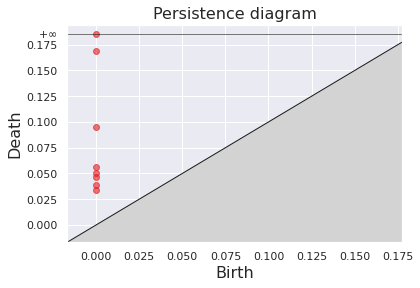

In [14]:
# Building Vietoris-Rips complex 
skeleton_word2vec = gd.RipsComplex(
    distance_matrix=cardinal_direction_pairwise_word_distances,
    # max_edge_length=0.8
)

simplex_tree = skeleton_word2vec.create_simplex_tree(max_dimension=2)
barcodes = simplex_tree.persistence()
gd.plot_persistence_diagram(barcodes)
plt.show()